# Challenge on stable binary compounds: Final prediction with multilabel model and feature engineering    
__Author: Dario Rocca__

Based on the previous work I believe that a multilabel classifier is a better approach to predict a full stability vector. Multilabel random forests (or neural networks) “naturally” keep into account the correlation between labels. For example, the stability of the (90% A-10% B) compound might have implication on the stability of (80% A-20% B).
From a practical point of view it is easy to train this type of model to optimize subset accuracy, namely accuracy on the full stability vector.

In this notebook I will use the compound specific features already introduced in the binary_classifier.ipynb notebook. However, in this case I will not "unroll" the data. For example, I will introduce the weighted average features 0.9*featureA+0.1*featureB for the (90%A-10%B) compound and similar ones for other stoichiometries. Differently from the previous work on the binary classifier, a feature such as 0.9*featureA+0.1*featureB  will contribute to the full stability vector prediction and not only the corresponding stoichiometry.     

## Loading data

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading the training set with Pandas

train=pd.read_csv("training_data.csv") # creating the train dataframe

#Following Ubaru et al. PRB 95, 214102 (2017)
#I introduce here some new elemental properties which were missing in the data provided
#Cohesive energy, Enthalpy of Vaporization and Electron Affinity.
#Source of the data http://phases.imet-db.ru/elements/main.aspx (I checked some data and it seems reliable)

cohesiveE=pd.read_csv("cohesive_energy.csv")            # Loading cohesive energies for each element
enthalpy_vap=pd.read_csv("enthalpy_vaporization.csv")   # Loading enthalpy of vaporization for each element
elec_affinity=pd.read_csv("electron_affinity.csv")      # Loading electron affinity for each element

# For convenience I'm setting the index of the dataframe to be the atom label
cohesiveE=cohesiveE.set_index('atom')
enthalpy_vap=enthalpy_vap.set_index('atom')
elec_affinity=elec_affinity.set_index('atom')

# For convenience the series is transformed into a dictionary
cohesiveE_dic=cohesiveE['energy'].to_dict()
enthalpy_vap_dic=enthalpy_vap['energy'].to_dict()
elec_affinity_dic=elec_affinity['energy'].to_dict()

# I create the new features columns; at this stage these columns
# contain only the atoms name
train["formulaA_cohesiveE"]=train["formulaA"]
train["formulaB_cohesiveE"]=train["formulaB"]
train["formulaA_enthalpy_vap"]=train["formulaA"]
train["formulaB_enthalpy_vap"]=train["formulaB"]
train["formulaA_elec_affinity"]=train["formulaA"]
train["formulaB_elec_affinity"]=train["formulaB"]

# Using the dictionaries I replace in the previously created columns the
# name of the element with its corresponding property
train=train.replace({"formulaA_cohesiveE": cohesiveE_dic})
train=train.replace({"formulaB_cohesiveE": cohesiveE_dic})
train=train.replace({"formulaA_enthalpy_vap": enthalpy_vap_dic})
train=train.replace({"formulaB_enthalpy_vap": enthalpy_vap_dic})
train=train.replace({"formulaA_elec_affinity": elec_affinity_dic})
train=train.replace({"formulaB_elec_affinity": elec_affinity_dic})

original_columns = list(train.columns) # List with the columns of the original dataframe

__Below some manipulations that will be useful later.__

In [3]:
# Creating 2 lists that contain the name of the features (columns) corresponding
# to element A and B

columns_A = [] # List that will contain the name of the columns containing the descriptors of element A
columns_B = [] # Same thing for element B

for col in list(train.columns):
    if ('formulaA' in col):
        columns_A.append(col)
    if ('formulaB' in col):
        columns_B.append(col)

# Adding avg_coordination_A (or B) and avg_nearest_neighbor_distance_A (or B) that do not contain
# the string formulaA or formulaB
columns_A.append('avg_coordination_A')
columns_A.append('avg_nearest_neighbor_distance_A')

columns_B.append('avg_coordination_B')
columns_B.append('avg_nearest_neighbor_distance_B')

In [4]:
# The labels to predict are strings of the form "[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0]"
# Below I will extract the corresponding list

import ast

list_label = train['stabilityVec'].tolist()    # A list that contains the column 'stabilityVec'
list_label = map(ast.literal_eval,list_label)
list_label_np = np.asarray(list_label)

#Let's drop the stability index of the pure element, as we do not need to predict it
list_label_compound = list_label_np[:,1:10]

## Feature engineering

The features engineered below were the most effective in the binary classifier model developed in the binary_classifier.ipynb notebook.   

In [5]:
# I (re)discovered the differences and weighted average features on my own
# However, they were already used together with the average deviation
# in Ward et al. npj Computational Materials 2, 16028 (2016).

for i in range(1,len(columns_A)):
    col_name_diff = "diff_"+columns_A[i]
    train[col_name_diff]=abs(train[columns_A[i]]-train[columns_B[i]])
    for percentage_A in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]: 
        percentage_B = 1.0 - percentage_A
        col_name_mean = "mean_"+columns_A[i]+str(percentage_A)+str(percentage_B)
        col_name_dev = "dev_"+columns_A[i]+str(percentage_A)+str(percentage_B)
        train[col_name_mean]=(percentage_A*train[columns_A[i]]
                              +percentage_B*train[columns_B[i]])
        train[col_name_dev]=(percentage_A*
                             abs(train[columns_A[i]]-train[col_name_mean])
                             +percentage_B*
                             abs(train[columns_B[i]]-train[col_name_mean]))
        
# There is a little "mistake": I should not compute the weighted averages of
# categorical variables; I don't think this changes a lot the final result
# but eventually I should correct it and retrain the model

##################################################

#The following features correspond to the valence orbital occupation attributes 
#These features have been proposed in Meredig et al. PRB 89 094104 (2014)

for precentage_A in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    percentage_B = 1.0 - precentage_A
    
    train["Fs"]=((percentage_A*train["formulaA_elements_NsValence"]
                       +percentage_B*train["formulaB_elements_NsValence"])/
                       (percentage_A*train["formulaA_elements_NValance"]
                       +percentage_B*train["formulaB_elements_NValance"]))
    train["Fp"]=((percentage_A*train["formulaA_elements_NpValence"]
                       +percentage_B*train["formulaB_elements_NpValence"])/
                       (percentage_A*train["formulaA_elements_NValance"]
                       +percentage_B*train["formulaB_elements_NValance"]))
    train["Fd"]=((percentage_A*train["formulaA_elements_NdValence"]
                       +percentage_B*train["formulaB_elements_NdValence"])/
                       (percentage_A*train["formulaA_elements_NValance"]
                       +percentage_B*train["formulaB_elements_NValance"]))            
    train["Ff"]=((percentage_A*train["formulaA_elements_NfValence"]
                       +percentage_B*train["formulaB_elements_NfValence"])/
                       (percentage_A*train["formulaA_elements_NValance"]
                       +percentage_B*train["formulaB_elements_NValance"]))

##################################################

## Training a multilabel model and validate it

I will keep a 10% hold out test set for validation.

In [6]:
# Importing sklearn
from sklearn.model_selection import train_test_split


# Dropping the original features - i will keep only the engineered ones
X_tot = train.drop(original_columns, axis=1) 
Y_tot = list_label_compound


# Holding out 10% of the data to test the model 
X_train, X_test, Y_train, Y_test = train_test_split(X_tot, Y_tot, test_size=0.1, random_state=0)

print "Number of features",len(X_train.columns)

Number of features 973


By using 10-fold cross validation on the training set I performed a grid search for the best parameters for the random forest multilabel classifier. I used as scoring function the accuracy_score function, which is equivalent to subset accuracy.  The code lines corresponding to the grid search take a lot of time to execute and have been commented. With the optimized parameters I then evaluate the performance on the hold out test set.

In [13]:
# Importing sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import coverage_error 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import make_scorer

################################################################################

####### The following commented lines have been used to optimize the RandomForestClassifier parameters
####### This takes some time 

## Important parameters to optimize: n_estimators, max_features, and max_depth
#search_grid_rf = [{'n_estimators': [50, 100, 150, 200, 250, 300],
#                  'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
#                  'max_depth': [14, 18, 22, 26, 30]}] 

# I'm using subset accuracy as score function
#subsetacc = make_scorer(accuracy_score)
#multilabel_rf = GridSearchCV(RandomForestClassifier(random_state=0), search_grid_rf, cv=10,
#                        scoring=subsetacc, verbose=10, n_jobs=4)

#multilabel_rf.fit(X_train, Y_train)

#print "Best parameters set found on traning set:"
#print ""
#print multilabel_rf.best_params_
#print ""
#print "Grid scores on training set:"
#print ""

#means = multilabel_rf.cv_results_['mean_test_score']
#stds = multilabel_rf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, multilabel_rf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#            % (mean, std * 2, params))
#print ""

#Best parameters set found on traning set:

#{'max_features': 0.4, 'n_estimators': 100, 'max_depth': 30}

#0.623 (+/-0.064) for {'max_features': 0.4, 'n_estimators': 100, 'max_depth': 30}

################################################################################

# The multilabel classifier
multilabel_rf = RandomForestClassifier(max_features = 0.4, n_estimators = 100, max_depth = 30, random_state=0)
# With the parameters above I got 0.623 (+/-0.064) as best score (subset accuracy) in the grid search
# random_state=0 allows for reproducibility; alternatively we could release this constraint 
# and average over different final results

###########################

multilabel_rf.fit(X_train, Y_train)
predictions_train = multilabel_rf.predict(X_train)

print "Detailed classification report:"
print ""
print "The model is trained on the training set."
print("The scores are computed on the hold out test set.")
print ""
print(classification_report(Y_train, predictions_train))
print ""

print "Subset accuracy (accuracy on full stability vector)", accuracy_score(Y_train, predictions_train)


###########################

predictions_test = multilabel_rf.predict(X_test)

print "Detailed classification report:"
print ""
print "The model is trained on the training set."
print("The scores are computed on the hold out test set.")
print ""
print(classification_report(Y_test, predictions_test))
print ""

print "Subset accuracy (accuracy on full stability vector)", accuracy_score(Y_test, predictions_test)

Detailed classification report:

The model is trained on the training set.
The scores are computed on the hold out test set.

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        47
          1       1.00      1.00      1.00        77
          2       1.00      1.00      1.00       537
          3       1.00      1.00      1.00       156
          4       1.00      1.00      1.00       522
          5       1.00      1.00      1.00       170
          6       1.00      1.00      1.00       324
          7       1.00      1.00      1.00       352
          8       1.00      1.00      1.00        51

avg / total       1.00      1.00      1.00      2236


Subset accuracy (accuracy on full stability vector) 1.0
Detailed classification report:

The model is trained on the training set.
The scores are computed on the hold out test set.

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         

__Remarks__ <br>
- In 10-fold cross validation I obtained 0.623 (+/-0.064) as best subset accuracy. 
- On the hold out test set I obtain a 0.62 f1 score with a precision (0.8) that is sizeably higher than the recall (0.53). The subset accuracy on the hold out test set is 0.65.   

__Looking for the 10 most important features in the RF multilabel classifier__ 

Feature ranking in the random forest algorithm (top 10):
1. feature mean_formulaA_elements_Column0.50.5 (2.348871)
2. feature mean_formulaA_elements_GSbandgap0.50.5 (1.124711)
3. feature mean_formulaA_elements_Column0.40.6 (1.104977)
4. feature mean_formulaA_elements_CovalentRadius0.10.9 (1.045030)
5. feature mean_formulaA_elements_CovalentRadius0.90.1 (1.003792)
6. feature mean_formulaA_elements_MendeleevNumber0.90.1 (0.891564)
7. feature mean_formulaA_elements_Polarizability0.10.9 (0.825993)
8. feature mean_formulaA_elements_GSbandgap0.60.4 (0.735998)
9. feature mean_formulaA_elements_Column0.60.4 (0.729924)
10. feature mean_formulaA_elements_GSbandgap0.40.6 (0.698317)


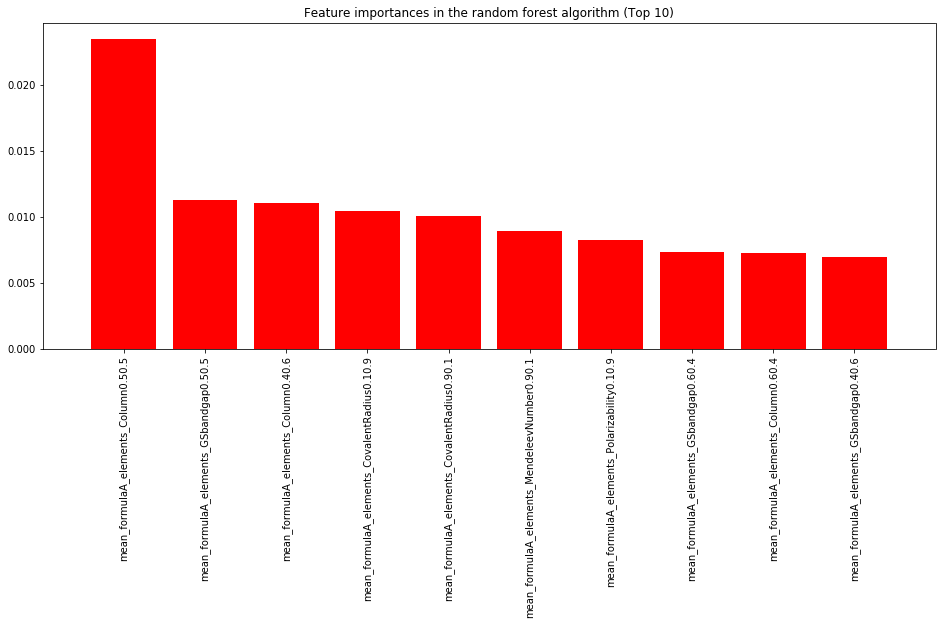

In [8]:
importances = multilabel_rf.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking

n_to_plot = 10 

print ("Feature ranking in the random forest algorithm (top %i):" % n_to_plot)
Features=[]
for f in range(n_to_plot):
    index = indices[f]
    feat = X_train.columns[index]
    print("%d. feature %s (%f)" % (f + 1, feat, importances[index]*100))
    Features.append(feat)

# Plot the feature importances of the random forest
plt.figure(figsize=[16,6])
plt.title("Feature importances in the random forest algorithm (Top %i)" % n_to_plot)
plt.bar(range(n_to_plot), importances[indices[0:n_to_plot]],
       color="r", align="center")
plt.xticks(range(n_to_plot), Features, rotation='vertical')
plt.xlim([-1, n_to_plot])
plt.show()

## Making the final predictions

In order to make the final predictions I will load the test_data.csv file in the topredict dataframe. Then I need to build all the engineered features also in this dataframe.

In [9]:
topredict=pd.read_csv("test_data.csv")
submission = topredict.copy() # keeping this datafarme aside to write the final csv file

#Following Ubaru et al. PRB 95, 214102 (2017)
#I introduce here some new elemental properties which were missing in the data provided
#Cohesive energy, Enthalpy of Vaporization and Electron Affinity.
#Source of the data http://phases.imet-db.ru/elements/main.aspx (I checked some data and it seems reliable)

cohesiveE=pd.read_csv("cohesive_energy.csv")            # Loading cohesive energies for each element
enthalpy_vap=pd.read_csv("enthalpy_vaporization.csv")   # Loading enthalpy of vaporization for each element
elec_affinity=pd.read_csv("electron_affinity.csv")      # Loading electron affinity for each element

# For convenience I'm setting the index of the dataframe to be the atom label
cohesiveE=cohesiveE.set_index('atom')
enthalpy_vap=enthalpy_vap.set_index('atom')
elec_affinity=elec_affinity.set_index('atom')

# For convenience the series is transformed into a dictionary
cohesiveE_dic=cohesiveE['energy'].to_dict()
enthalpy_vap_dic=enthalpy_vap['energy'].to_dict()
elec_affinity_dic=elec_affinity['energy'].to_dict()

# I create the new features columns; at this stage these columns
# contain only the atoms name
topredict["formulaA_cohesiveE"]=topredict["formulaA"]
topredict["formulaB_cohesiveE"]=topredict["formulaB"]
topredict["formulaA_enthalpy_vap"]=topredict["formulaA"]
topredict["formulaB_enthalpy_vap"]=topredict["formulaB"]
topredict["formulaA_elec_affinity"]=topredict["formulaA"]
topredict["formulaB_elec_affinity"]=topredict["formulaB"]

# Using the dictionaries I replace in the previously created columns the
# name of the element with its corresponding property
topredict=topredict.replace({"formulaA_cohesiveE": cohesiveE_dic})
topredict=topredict.replace({"formulaB_cohesiveE": cohesiveE_dic})
topredict=topredict.replace({"formulaA_enthalpy_vap": enthalpy_vap_dic})
topredict=topredict.replace({"formulaB_enthalpy_vap": enthalpy_vap_dic})
topredict=topredict.replace({"formulaA_elec_affinity": elec_affinity_dic})
topredict=topredict.replace({"formulaB_elec_affinity": elec_affinity_dic})

original_columns_topredict = list(topredict.columns)

In [10]:
for i in range(1,len(columns_A)):
    col_name_diff = "diff_"+columns_A[i]
    topredict[col_name_diff]=abs(topredict[columns_A[i]]-topredict[columns_B[i]])
    for percentage_A in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]: 
        percentage_B = 1.0 - percentage_A
        col_name_mean = "mean_"+columns_A[i]+str(percentage_A)+str(percentage_B)
        col_name_dev = "dev_"+columns_A[i]+str(percentage_A)+str(percentage_B)
        topredict[col_name_mean]=(percentage_A*topredict[columns_A[i]]
                              +percentage_B*topredict[columns_B[i]])
        topredict[col_name_dev]=(percentage_A*
                             abs(topredict[columns_A[i]]-topredict[col_name_mean])
                             +percentage_B*
                             abs(topredict[columns_B[i]]-topredict[col_name_mean]))
 

for precentage_A in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    percentage_B = 1.0 - precentage_A
    
    topredict["Fs"]=((percentage_A*topredict["formulaA_elements_NsValence"]
                       +percentage_B*topredict["formulaB_elements_NsValence"])/
                       (percentage_A*topredict["formulaA_elements_NValance"]
                       +percentage_B*topredict["formulaB_elements_NValance"]))
    topredict["Fp"]=((percentage_A*topredict["formulaA_elements_NpValence"]
                       +percentage_B*topredict["formulaB_elements_NpValence"])/
                       (percentage_A*topredict["formulaA_elements_NValance"]
                       +percentage_B*topredict["formulaB_elements_NValance"]))
    topredict["Fd"]=((percentage_A*topredict["formulaA_elements_NdValence"]
                       +percentage_B*topredict["formulaB_elements_NdValence"])/
                       (percentage_A*topredict["formulaA_elements_NValance"]
                       +percentage_B*topredict["formulaB_elements_NValance"]))            
    topredict["Ff"]=((percentage_A*topredict["formulaA_elements_NfValence"]
                       +percentage_B*topredict["formulaB_elements_NfValence"])/
                       (percentage_A*topredict["formulaA_elements_NValance"]
                       +percentage_B*topredict["formulaB_elements_NValance"]))

##################################################

In [11]:
# Dropping the original features - i will keep only the engineered ones
X_topredict = topredict.drop(original_columns_topredict, axis=1) 

# final predictions
final_predictions = multilabel_rf.predict(X_topredict)

#Proper formatting for the stability vector (I have to add also the pure element stability)
predicted_vector = []
for i in final_predictions:
    predicted_string = ("[1.0,"+str(i[0])+","+str(i[1])+","+str(i[2])+","+str(i[3])+","+str(i[4])
           +","+str(i[5])+","+str(i[6])+","+str(i[7])+","+str(i[8])+",1.0]")
    predicted_vector.append(predicted_string)

# writing the dataframe with predictions to csv file
submission["stabilityVec"]=predicted_vector
submission.to_csv('final.csv', index=False)

## Conclusions 

I trained the parameters of the model with 10-fold cross-validation and using subset accuracy as scoring function. __On the test set I obtained a 65% subset accuracy.__ As a reference, by considering all the labels as equal to 0 the subset accuracy would be 52%. Subset accuracy is a very strict metric as it indicates the percentage of samples that have all their labels classified correctly. As shown above certain classes have sizeably lower f1-score and this has implications for the overall subset accuracy.  